# Data Analysis 3: Assignment 1 - Ambrus Fodor

## Part I. Modelling

1. Go to inside airbnb and pick a city. Your core dataset should have at least 10K rows. Go back in time and download listings data for an earlier quarter. (3p)

* Carry out data wrangling such as extracting amenities and imputing missing values. 

* Think about the process before jumping in and explain your variable selection and feature engineering choices. 

* You can use the code of the case study or AI for coding. 

In [1]:
#For kernel select the one for the course
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Import packages
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.formula.api as smf
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

/home/ambrus2/miniconda3/envs/daenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Load the data
training_data = pd.read_csv('https://raw.githubusercontent.com/4mbrus/Data-Analysis-3/refs/heads/main/Assignment%201/LA_listings_Q2.csv')

In [4]:
#Exploraition
print("Initial number of rows:", len(training_data))
print(training_data.info())
training_data.head()

Initial number of rows: 41421
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41421 entries, 0 to 41420
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            41421 non-null  int64  
 1   listing_url                                   41421 non-null  object 
 2   scrape_id                                     41421 non-null  int64  
 3   last_scraped                                  41421 non-null  object 
 4   source                                        41421 non-null  object 
 5   name                                          41420 non-null  object 
 6   description                                   40492 non-null  object 
 7   neighborhood_overview                         18529 non-null  object 
 8   picture_url                                   41421 non-null  object 
 9   host_id                        

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2708,https://www.airbnb.com/rooms/2708,20250617032927,2025-06-17,city scrape,"Run Runyon, Beaut Furn Mirror Mini-Suit w/ Fir...",Run Runyon Canyon<br /><br />Gym & Sauna <br /...,"Walk and run to Runyon Canyon, it is open!<br ...",https://a0.muscache.com/pictures/hosting/Hosti...,3008,...,4.98,4.95,4.86,NaN,t,2,0,2,0,0.33
1,2732,https://www.airbnb.com/rooms/2732,20250617032927,2025-06-17,city scrape,Zen Life at the Beach,An oasis of tranquility awaits you.,"This is the best part of Santa Monica. Quiet, ...",https://a0.muscache.com/pictures/1082993/c5a99...,3041,...,4.48,4.91,4.22,228269,f,2,1,1,0,0.14
2,2864,https://www.airbnb.com/rooms/2864,20250617032927,2025-06-17,previous scrape,* Beautiful Master Suite/Jacuzzi Tub/*,Centrally located.... Furnished with King Size...,What makes the neighborhood unique is that the...,https://a0.muscache.com/pictures/23817858/de20...,3207,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
3,6033,https://www.airbnb.com/rooms/6033,20250617032927,2025-06-17,previous scrape,Poolside Serenity Studio,Our distinctive bachelor's studio for 1-3 gues...,NaN,https://a0.muscache.com/pictures/458111/986c76...,11619,...,4.35,4.65,4.29,NaN,f,6,3,3,0,0.10
4,6931,https://www.airbnb.com/rooms/6931,20250617032927,2025-06-17,city scrape,"RUN Runyon, Beau Furn Rms Terrace Hollyw Hill ...",Run Runyon Canyon & Views<br /><br />Gym & Sau...,We are in the middle of one of the great citie...,https://a0.muscache.com/pictures/miso/Hosting-...,3008,...,4.91,4.71,4.76,NaN,t,2,0,2,0,0.19


In [5]:
#print nan value summary
nan_summary = training_data.isna().sum()
print("Number of missing values per column:")
print(nan_summary)

Number of missing values per column:
id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
source                                              0
                                                ...  
calculated_host_listings_count                      0
calculated_host_listings_count_entire_homes         0
calculated_host_listings_count_private_rooms        0
calculated_host_listings_count_shared_rooms         0
reviews_per_month                               11502
Length: 79, dtype: int64


In [6]:
def clean_airbnb_dataset(input_df, center_lat, center_lon):
    """
    Takes a raw Airbnb dataset, cleans it, handles missing values, 
    visualizes distributions, and returns a processed DataFrame.
    """
    # Create a copy to avoid SettingWithCopy warnings on the original dataset
    df = input_df.copy()
    print("--- Starting Data Cleaning Pipeline ---")
    print(f"Original shape: {df.shape}")

    # --------------------------------------------------------------------------------
    # 1. Data Wrangling & Dropping Columns
    # --------------------------------------------------------------------------------
    # License is missing in 71% of rows, we will drop it.
    # Drop other irrelevant columns to make the dataset more manageable.
    # URLs and text-based columns are not useful for this specific model.
    cols_to_drop = [
        'license','listing_url','scrape_id', 'last_scraped','source','picture_url',
        'host_thumbnail_url', 'host_picture_url', 'neighbourhood', 'calendar_updated', 
        'calendar_last_scraped', 'neighborhood_overview', 'host_url', 'description', 
        'name', 'host_about', 'host_verifications', 'bathrooms_text', 'neighbourhood_cleansed', #because we will need the models to work on an other city we need to drop the neighborhood
        'neighbourhood_group_cleansed', 'availability_30', 'availability_60', 'availability_90', # Redundant, highly correlated
        'host_location', "host_identity_verified", 'host_has_profile_pic',
        'host_neighbourhood', 'host_name', "estimated_revenue_l365d",
        'has_availability', 'minimum_minimum_nights', 'maximum_minimum_nights',
        'minimum_maximum_nights', 'maximum_maximum_nights', 
        'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm' # Redundant to price
    ]
    df = df.drop(columns=cols_to_drop, errors='ignore')

    # Drop row where availability_365 is 0. 
    # It is not plausible that a property is listed but not available for the whole year.
    df = df[df['availability_365'] != 0]

    # Host Response Time: Values are so one-sided that it is doubtful it has explanatory power.
    if 'host_response_time' in df.columns:
        # Optional: Print distribution to prove the point to the grader
        # print(df["host_response_time"].value_counts()) 
        df.drop(columns="host_response_time", inplace=True)

    # Since there are still rows with missing price values, we drop those.
    # Imputing prices (the target variable) would lower the quality of our models.
    df = df.dropna(subset=['price'])

    # Drop the few rows where crucial structural columns have missing values.
    df = df.dropna(subset=['bedrooms', 'bathrooms', 'beds'])
    
    print("Step 1 Complete: Structural columns dropped.")

    # --------------------------------------------------------------------------------
    # 2. Correct Data Types
    # --------------------------------------------------------------------------------
    # Clean Price and convert to float
    if df['price'].dtype == 'object':
        df['price'] = df['price'].str.replace('$','', regex=False).str.replace(',','', regex=False).astype(float)
    
    # Clean percentages
    for col in ['host_response_rate', 'host_acceptance_rate']:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace('%','', regex=False).astype(float)

    # Boolean mapping
    # Assume missing superhost status means not a superhost
    df['host_is_superhost'] = df['host_is_superhost'].fillna('f').map({'t': 1, 'f': 0}) 
    df['instant_bookable'] = df['instant_bookable'].map({'t': 1, 'f': 0})

    # --------------------------------------------------------------------------------
    # 3. Feature Engineering (Dates)
    # --------------------------------------------------------------------------------
    now = pd.to_datetime('today')
    
    # Calculate Host Age
    df['host_since'] = pd.to_datetime(df['host_since'])
    df['host_age_months'] = (now - df['host_since']).dt.days // 30
    df.drop(columns=['host_since'], inplace=True)

    # Calculate Listing Age
    df['first_review'] = pd.to_datetime(df['first_review'])
    df['listing_age_months'] = (now - df['first_review']).dt.days // 30
    df.drop(columns=['first_review', 'last_review'], inplace=True, errors='ignore')

    # --------------------------------------------------------------------------------
    # 4. Amenities Processing
    # --------------------------------------------------------------------------------
    # New column: Amenities count
    def count_amenities(amenities):
        if pd.isna(amenities): return 0
        return len(amenities.split(','))

    df['amenities_count'] = df['amenities'].apply(count_amenities)

    # Create dummy variables for specific amenities
    amenity_list = [
        'Wifi', 'Air conditioning', 'AC', 'Kitchen', 'Dryer', 'Heating', 'Washer', 'TV', 
        'Pool', 'Gym', 'Balcony', 'Fireplace', 'Hot_tub', 'Garden', 'Pets allowed', 
        'Parking', 'Host greets you', 'Sauna', 'Stove', 'HBO', 'Netflix', 'Hulu', 
        'Disney+', 'Amazon Prime Video', 'Coffee maker', 'Refrigerator', 'Oven', 
        'Microwave', 'View', 'Beachfront'
    ]

    for amenity in amenity_list:
        df[amenity] = df['amenities'].str.contains(amenity, case=False, regex=False, na=False).astype(int)

    # Merge Streaming Services into one variable
    streaming_cols = ['HBO', 'Netflix', 'Hulu', 'Disney+', 'Amazon Prime Video']
    df['Streaming services'] = df[streaming_cols].max(axis='columns')
    df.drop(columns=streaming_cols, inplace=True)

    # Merge AC and Air Conditioning
    df['Air conditioning'] = df[['Air conditioning', 'AC']].max(axis='columns')
    if 'AC' in df.columns: df.drop(columns=['AC'], inplace=True)
    
    # Drop original amenities text column
    df.drop(columns=['amenities'], inplace=True)
    
    print("Step 4 Complete: Amenities processed and dummy variables created.")

    # --------------------------------------------------------------------------------
    # 5. Handling Missing Reviews (Visual Check)
    # --------------------------------------------------------------------------------
    # Reviews with missing related columns need checking; likely new listings.
    missing_reviews = df[df['listing_age_months'].isna()]

    print(f"\nVisual Check: found {len(missing_reviews)} listings with missing reviews.")
    
    # PLOT 1: Histogram Comparison
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    axs[0].hist(missing_reviews['price'], bins=range(0,5000,50), color='blue', alpha=0.7)
    axs[0].set_title('Price Dist: Listings with Missing Reviews')
    axs[0].set_xlabel('Price')
    axs[0].set_ylabel('Frequency')
    
    axs[1].hist(df['price'], bins=range(0,5000,50), color='orange', alpha=0.7)
    axs[1].set_title('Price Dist: All Listings')
    axs[1].set_xlabel('Price')
    axs[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show() # This will render in the notebook
    
    print("Interpretation: Distribution is normal. Assuming these are new listings.")

    # Impute missing values for new listings/hosts
    fill_values = {
        "number_of_reviews": 0,
        "reviews_per_month": 0,
        "listing_age_months": 0,
        "host_age_months": df["host_age_months"].mean(),
        "host_response_rate": df["host_response_rate"].mean(),
        "host_acceptance_rate": df["host_acceptance_rate"].mean()
    }
    # Handle listing counts if present
    if "calculated_host_listings_count" in df.columns:
        fill_values["host_listings_count"] = df["calculated_host_listings_count"]
        fill_values["host_total_listings_count"] = df["calculated_host_listings_count"]
        
    df.fillna(fill_values, inplace=True)

    # --------------------------------------------------------------------------------
    # 6. Dealing with Extreme Values (Outliers)
    # --------------------------------------------------------------------------------
    # PLOT 2: Boxplot for Property Type
    # High cardinality check + Outlier check
    print("\nVisual Check: Analyzing extreme values by property type...")
    
    # Temporary simplification for the plot (so the x-axis isn't messy)
    # We will do the actual simplification in Step 7
    fig, ax = plt.subplots(figsize=(15, 6))
    df.boxplot(column='price', by='property_type', ax=ax, grid=False, rot=90)
    plt.suptitle('') # Remove default pandas title
    ax.set_title('Boxplot of Price by Property Type (Raw)')
    plt.show()

    # Cap prices at the 99th percentile
    price_99th = df['price'].quantile(0.99)
    print(f"Capping prices at 99th percentile: ${price_99th:.2f}")
    df = df[df['price'] <= price_99th]

    # --------------------------------------------------------------------------------
    # 7. Dealing with High Cardinality
    # --------------------------------------------------------------------------------
    # I. Property Types
    def simplify_property_type(prop):
        p = str(prop).lower()
        if 'entire' in p: return 'Entire Home/Apt'
        elif 'private room' in p: return 'Private Room'
        elif 'shared room' in p: return 'Shared Room'
        elif any(x in p for x in ['hotel', 'hostel', 'aparthotel', 'resort']): return 'Hotel/Commercial'
        elif any(x in p for x in ['tiny', 'camper', 'rv', 'tent', 'yurt', 'dome']): return 'Unique/Glamping'
        else: return 'Other'

    df['property_type'] = df['property_type'].apply(simplify_property_type)

    # --------------------------------------------------------------------------------
    # 8. Advanced Imputation (Review Scores)
    # --------------------------------------------------------------------------------
    # Using Iterative Imputer for the 8K missing review scores rather than dropping them.
    reviews_to_fix = [
        "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness", 
        "review_scores_checkin", "review_scores_communication", 
        "review_scores_location", "review_scores_value"
    ]
    
    anchors = [
        'price', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'bathrooms', 
        'host_is_superhost', 'host_response_rate', 'host_acceptance_rate',
        'listing_age_months', 'amenities_count', 'instant_bookable', 'Pool'
    ]

    # Filter strictly to columns that exist in the dataframe to avoid errors
    available_cols = [c for c in reviews_to_fix + anchors if c in df.columns]
    
    print("Running Iterative Imputer...")
    it_imp = IterativeImputer(max_iter=10, random_state=42, verbose=2)
    imputed_data = it_imp.fit_transform(df[available_cols])
    
    # Update the dataframe with imputed values
    # The imputer returns the columns in the same order they were passed in
    df[available_cols] = imputed_data

    # --------------------------------------------------------------------------------
    # 9. Handling latitude and longitude (Disclamer this is generated mostly by AI)
    # --------------------------------------------------------------------------------
    #Every city has different latitude and longituteds, but a common thing is that airbnbs near the center are more expensive than far away
    #Transform latitude and longitude into relatives
    # 1. Calculate Relative Coordinates (Offset from center)
    df['delta_lat'] = df['latitude'] - center_lat
    df['delta_lon'] = df['longitude'] - center_lon

    # 2. Calculate Haversine Distance (Distance to center in KM)
    # Convert degrees to radians
    R = 6371  # Earth radius in km
    phi1 = np.radians(df['latitude'])
    phi2 = np.radians(center_lat)
    delta_phi = np.radians(df['latitude'] - center_lat)
    delta_lambda = np.radians(df['longitude'] - center_lon)

    # Haversine formula
    a = np.sin(delta_phi / 2)**2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    df['dist_to_center_km'] = R * c
    
    df.drop(columns=['latitude', 'longitude'], inplace=True)


    print(f"Cleaning Complete. Final shape: {df.shape}")
    return df

--- Starting Data Cleaning Pipeline ---
Original shape: (41421, 79)
Step 1 Complete: Structural columns dropped.
Step 4 Complete: Amenities processed and dummy variables created.

Visual Check: found 8604 listings with missing reviews.


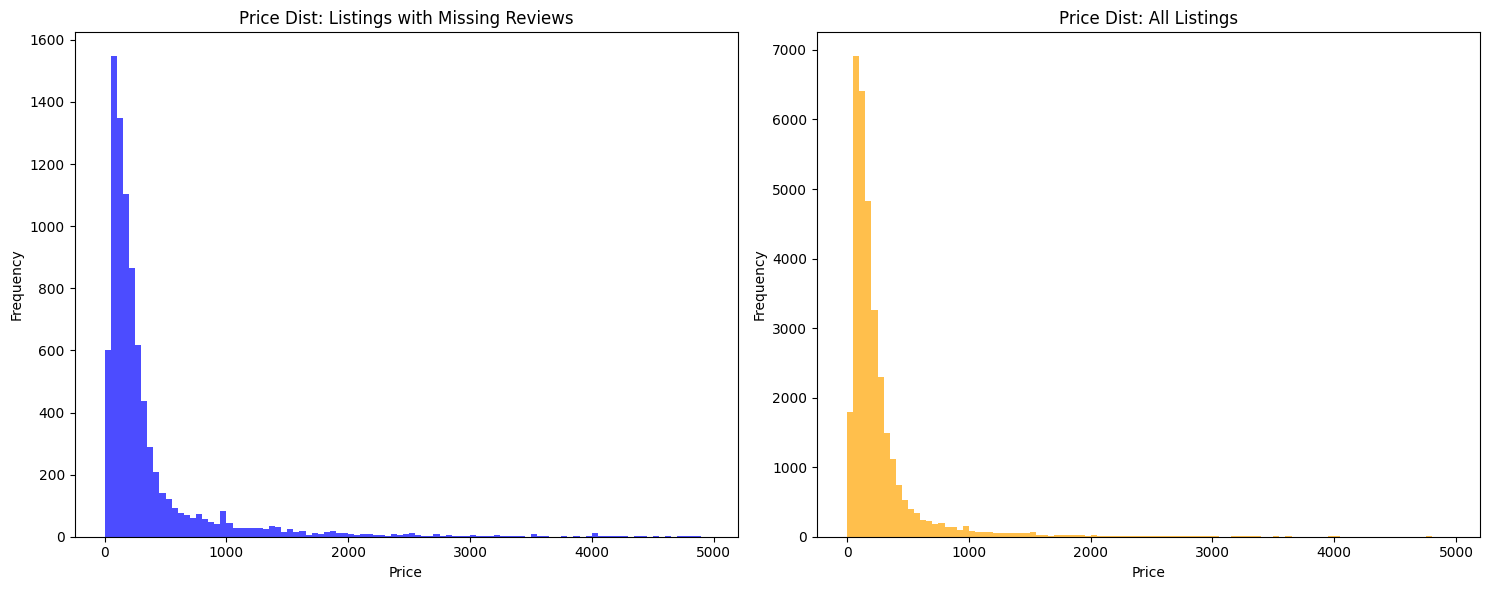

Interpretation: Distribution is normal. Assuming these are new listings.

Visual Check: Analyzing extreme values by property type...


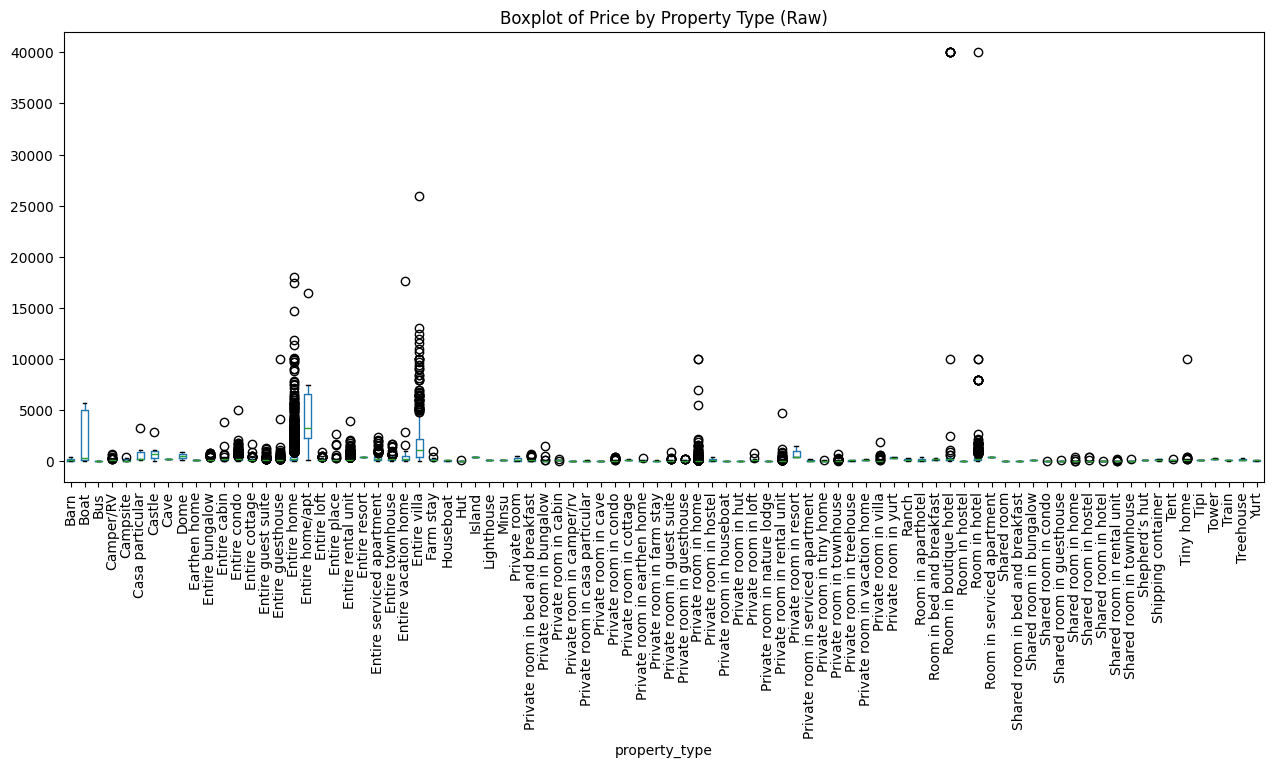

Capping prices at 99th percentile: $2500.00
Running Iterative Imputer...
[IterativeImputer] Completing matrix with shape (32539, 20)
[IterativeImputer] Ending imputation round 1/10, elapsed time 2.06
[IterativeImputer] Change: 8.924976928358623, scaled tolerance: 2.5 
[IterativeImputer] Ending imputation round 2/10, elapsed time 4.12
[IterativeImputer] Change: 2.980939714748127, scaled tolerance: 2.5 
[IterativeImputer] Ending imputation round 3/10, elapsed time 6.37
[IterativeImputer] Change: 0.6111685883385045, scaled tolerance: 2.5 
[IterativeImputer] Early stopping criterion reached.
Cleaning Complete. Final shape: (32539, 67)


In [7]:
cleaned_data = clean_airbnb_dataset(training_data, 34.0536, -118.2430)
training_data = cleaned_data

2. Build 5 different predictive models (3p)

   a. OLS  

   b. LASSO  

   c. Random Forest  

   d. Boosting of your choice  

   e. Something else of your choice. Could be another boosting algo, or something else.

In [8]:
# Prepare data for model fitting
# We drop the target and any leaks/IDs
drop_cols = ['price', 'id', 'host_id', 'estimated_revenue_l365d']

# Select numeric columns + categoricals
cat_cols = ['room_type', 'property_type']
num_cols = list(set(training_data.columns) - set(cat_cols)- set(drop_cols))

# Create dummy variables for the categoricals
X_cats = pd.get_dummies(training_data[cat_cols])
X_nums = training_data[num_cols]

# Combine them
X = pd.concat([X_nums, X_cats], axis=1)
y = training_data['price']

#replace spaces in column names
X.columns = [col.replace(' ', '_') for col in X.columns]

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
original_cols = X_train.columns

In [9]:
avg_model = [np.mean(y_train) for x in range(len(y_test))]

avg_rmse = np.sqrt(mean_squared_error(avg_model, y_test))
avg_r2 = r2_score(avg_model, y_test)
print("RMSE of taking the mean as a prediction:", avg_rmse)
print("R2 of taking the mean as a prediction:", np.round(avg_r2, 3))

RMSE of taking the mean as a prediction: 286.52577261700935
R2 of taking the mean as a prediction: -1.0163118615084253e+32


In [ ]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

#Use most important coefficents from xgboost, with some interactions
formula = """
price ~ 
    bathrooms + 
    bedrooms + 
    accommodates + 
    Pool + 
    Hot_tub + 
    reviews_per_month +
    property_type_Private_Room +
    review_scores_location +
    bedrooms:dist_to_center_km +
    accommodates:review_scores_location +
    bathrooms:property_type_Private_Room
"""

# Fit the model
# Note: Ensure your column names don't have spaces (replace with underscores if they do)
ols_final = smf.ols(formula=formula, data=df_train).fit()

# Display the statistical summary
print(ols_final.summary())

# Evaluate on Test Set
y_pred = ols_final.predict(df_test)


final_rmse = np.sqrt(mean_squared_error(df_test['price'], y_pred))
final_r2 = r2_score(df_test['price'], y_pred)

print(f"OLS RMSE: {final_rmse:.2f}")
print(f"OLS R2: {final_r2:.4f}")

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     2898.
Date:                Mon, 02 Feb 2026   Prob (F-statistic):               0.00
Time:                        23:25:39   Log-Likelihood:            -1.7491e+05
No. Observations:               26031   AIC:                         3.498e+05
Df Residuals:                   26020   BIC:                         3.499e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

In [ ]:
#Scale the Data for LASSO
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit LASSO with Cross-Validation
# alphas=None lets it search automatically
lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)

#Get results
y_pred_lasso = lasso.predict(X_test_scaled)

print(f"Best Alpha Found: {lasso.alpha_}")

# Calculate and save metrics
lasso_metrics = ["LASSO", np.sqrt(mean_squared_error(y_test, y_pred_lasso)), r2_score(y_test, y_pred_lasso), 0.9]
coefs = pd.Series(lasso.coef_, index=X.columns)
lasso_importances = coefs.abs().sort_values(ascending=False).head(15)
print(coefs[coefs == 0].index.tolist())

Best Alpha Found: 0.1900403205460391
['Hot_tub', 'property_type_Hotel/Commercial', 'property_type_Unique/Glamping']


In [ ]:
param_grid = {
    "n_estimators": [500],
    "max_features": ["sqrt"],
    "max_depth": [5, 10],
    "min_samples_leaf": [10,20],
    "min_samples_split": [30, 60]
}

rfr = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_random = GridSearchCV(
    estimator= rfr,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=2,
)

rf_random.fit(X_train, y_train)

y_pred_rf = rf_random.predict(X_test)

print(f"Best Score: {-rf_random.best_score_}")
print(f"Best Params: {rf_random.best_params_}")

rf_importances = pd.Series(rf_random.best_estimator_.feature_importances_, index=X_train.columns)
rf_importances = rf_importances.sort_values(ascending=False).head(15)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=30, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=60, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=60, n_estimators=500; total time=   0.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=60, n_estimat

In [ ]:
# Define the base model
gbr = GradientBoostingRegressor(
    random_state=42,
    subsample=0.8,              
    validation_fraction=0.1,    
    n_iter_no_change=10         
)

# Define the parameter grid
param_grid = {
    'n_estimators': [300],
    'learning_rate': [0.1],
    'max_depth': [5, 10],
    "min_samples_leaf": [10,20],
    "min_samples_split": [30, 60]
}

# Initialize Grid Search
grid_gbr = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=3
)

# Fit the search
grid_gbr.fit(X_train, y_train)

# Get the best model
best_gbr_model = grid_gbr.best_estimator_

# Get results using the tuned model
y_pred_gbr = best_gbr_model.predict(X_test)

# Print tuning results
print(f"Best Parameters: {grid_gbr.best_params_}")

# Extract feature importances
gbr_importances = pd.Series(best_gbr_model.feature_importances_, index=X.columns)
gbr_importances = gbr_importances.sort_values(ascending=False).head(15)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 4/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=10, min_samples_split=60, n_estimators=300;, score=-13163.422 total time=  41.4s
[CV 5/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=10, min_samples_split=60, n_estimators=300;, score=-15898.414 total time=  49.2s
[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=10, min_samples_split=60, n_estimators=300;, score=-13380.597 total time=  50.1s
[CV 3/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=10, min_samples_split=60, n_estimators=300;, score=-15690.366 total time=  49.6s
[CV 2/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=20, min_samples_split=30, n_estimators=300;, score=-13798.149 total time=  51.4s
[CV 5/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=10, min_samples_split=30, n_estimators=300;, score=-15446.334 total time=  57.2s
[CV 3/5] END learning_rate=0.1, max_depth=5, min_samples_leaf=10, min_samples_spli

In [ ]:
# Define the parameter grid
param_grid = {
    'max_depth': [5, 10],
    'learning_rate': [0.1],
    'colsample_bytree': [0.8, 1.0],
}

# Initialize the estimator 
# Note: n_estimators is high because early_stopping will cut it short
xgb_search_cv = xgb.XGBRegressor(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

# Setup GridSearchCV
# We use 'fit_params' to pass the eval_set to the underlying XGBoost fit method
grid_search = GridSearchCV(
    estimator=xgb_search_cv,
    param_grid=param_grid,
    cv=5, 
    scoring='neg_root_mean_squared_error',
    verbose=3
)

# Fit the grid search
grid_search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Get results from the best estimator
best_xgb_model = grid_search.best_estimator_
y_pred_gxb = best_xgb_model.predict(X_test)

# Save importances
xgb_importances = pd.Series(best_xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(15)

print(f"Best Params: {grid_search.best_params_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5;, score=-109.175 total time=   3.2s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5;, score=-109.407 total time=  13.6s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5;, score=-118.873 total time=   2.7s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5;, score=-108.132 total time=   0.8s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5;, score=-115.471 total time=   1.9s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10;, score=-109.920 total time=  10.4s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10;, score=-114.887 total time=  29.8s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10;, score=-121.240 total time=  17.5s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=10;, score=-111.653 total time=  11.4s
[CV 5/5] END colsa

3. Compare models in terms of fit and time. (3p)

* Create a horserace table. 

* Discuss performance. 

In [24]:
OLS_metrics = ["OLS", np.sqrt(mean_squared_error(df_test['price'], y_pred)), r2_score(df_test['price'], y_pred), 0]
lasso_metrics = ["LASSO", np.sqrt(mean_squared_error(y_test, y_pred_lasso)), r2_score(y_test, y_pred_lasso), 0.9]
rf_metrics = ["RF", np.sqrt(mean_squared_error(y_test, y_pred_rf)), r2_score(y_test, y_pred_rf), 46]
gbr_metrics = ["GBR", np.sqrt(mean_squared_error(y_test, y_pred_gbr)), r2_score(y_test, y_pred_gbr), 218.0]
xgb_metrics = ["XGB", np.sqrt(mean_squared_error(y_test, y_pred_gxb)), r2_score(y_test, y_pred_gxb), 208]

In [25]:
model_comparison_table = pd.DataFrame([OLS_metrics, lasso_metrics, rf_metrics, gbr_metrics, xgb_metrics],columns=["Model", "RMSE", "R2 Score", "Training Time (s)"])
model_comparison_table

,Model,RMSE,R2 Score,Training Time (s)
0,OLS,194.973959,0.536928,0.0
1,LASSO,185.515241,0.580768,0.9
2,RF,140.350173,0.760050,46.0
3,GBR,108.486168,0.856635,218.0
4,XGB,103.442583,0.869655,208.0


Both XGBoost and the standard Gradient Boosting Regressor (GBR) significantly outperform the Random Forest and LASSO models. With $R^2$ scores around 0.87, they are capturing roughly 22% more variance in the data than the Random Forest (altough RF was much faster, with more tuning it could probably come loser to the boosting methods).

With the time of 208 seconds, XGBoost is more faster than the standard gradient boost while delivering slightly better accuracy. This model is the clear winner in this case.

4. Take two models (RF and a boosting model) and analyze them. (3p)

* Show feature importance. 

* Compare the 10 most important features. 

* Discuss your findings. 

In [16]:
feature_importance_comparison_table = pd.concat(
    [lasso_importances.reset_index(), rf_importances.reset_index(), gbr_importances.reset_index(), xgb_importances.reset_index()],axis=1)

feature_importance_comparison_table.columns = ['Lasso','', 'Random Forest','', 'GBR','', 'XGBoost','']
feature_importance_comparison_table

,Lasso,,Random Forest,,GBR,,XGBoost,
0,bathrooms,115.567529,bathrooms,0.209612,bathrooms,0.375605,bathrooms,0.139421
1,accommodates,48.526132,bedrooms,0.132096,review_scores_location,0.126589,Pool,0.138069
2,bedrooms,43.717540,accommodates,0.099434,Pool,0.077151,property_type_Private_Room,0.133617
3,review_scores_value,35.697703,review_scores_location,0.075928,accommodates,0.062633,bedrooms,0.055886
4,Pool,33.292957,beds,0.073084,bedrooms,0.053062,review_scores_location,0.050355
5,delta_lon,32.505721,Pool,0.042414,delta_lon,0.036072,accommodates,0.040140
6,review_scores_location,29.997965,Fireplace,0.032248,delta_lat,0.034975,number_of_reviews,0.029939
7,calculated_host_listings_count,29.658305,delta_lon,0.031884,reviews_per_month,0.032970,property_type_Shared_Room,0.022535
8,beds,24.481505,delta_lat,0.015148,dist_to_center_km,0.013816,reviews_per_month,0.021199
9,delta_lat,24.144961,review_scores_value,0.015033,listing_age_months,0.013480,Beachfront,0.019039


In [17]:
feature_importance_comparison_table_2 = pd.concat(
    [rf_importances.reset_index(), xgb_importances.reset_index()],axis=1)

feature_importance_comparison_table_2.columns = ['Random Forest','','XGBoost','']
feature_importance_comparison_table_2.head(10)

,Random Forest,,XGBoost,
0,bathrooms,0.209612,bathrooms,0.139421
1,bedrooms,0.132096,Pool,0.138069
2,accommodates,0.099434,property_type_Private_Room,0.133617
3,review_scores_location,0.075928,bedrooms,0.055886
4,beds,0.073084,review_scores_location,0.050355
5,Pool,0.042414,accommodates,0.040140
6,Fireplace,0.032248,number_of_reviews,0.029939
7,delta_lon,0.031884,property_type_Shared_Room,0.022535
8,delta_lat,0.015148,reviews_per_month,0.021199
9,review_scores_value,0.015033,Beachfront,0.019039


The feature importance comparison reveals a stark difference in how the two models value property attributes, highlighting why XGBoost generally outperformed Random Forest. A key distinction lies in the distribution of weight: while both models agree bathrooms is the primary driver, Random Forest is far more reliant on it, assigning it a weight of over 0.20 compared to XGBoost’s 0.14. This suggests Random Forest behaves like a blunt "capacity calculator," heavily weighting raw size metrics like bedrooms and accommodates alongside specific coordinate offsets (delta_lon), which hints at overfitting to local geography. In contrast, XGBoost distributes its importance more evenly, placing nearly equal weight on property_type_Private_Room (~0.13) and prioritizing luxury signals like Pool and Beachfront. This indicates XGBoost learned a more nuanced, transferable definition of value—penalizing shared spaces and rewarding amenities—rather than just counting rooms or memorizing the map.

## Part II. Validity

5. Let us have two "live" datasets. (3p)

   A. Download another (later) date.  Repeat data wrangling

   B. Download another city in the same country or region, with at least 3K observations. Repeat data wrangling



/tmp/ipykernel_1718/1207247214.py:1: DtypeWarning: Columns (63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  testing_data_la = pd.read_csv('https://raw.githubusercontent.com/4mbrus/ceu-da3-hw1/refs/heads/main/LA_listings_Q1.csv')


--- Starting Data Cleaning Pipeline ---
Original shape: (41031, 79)
Step 1 Complete: Structural columns dropped.
Step 4 Complete: Amenities processed and dummy variables created.

Visual Check: found 8520 listings with missing reviews.


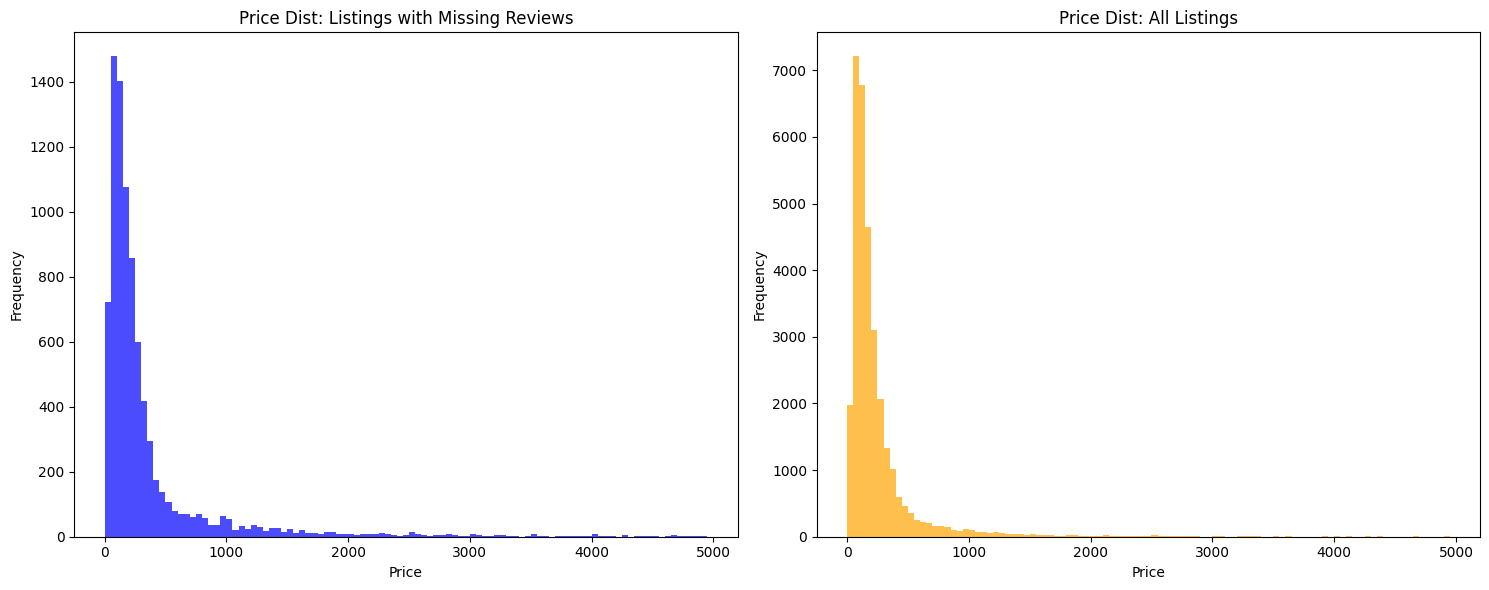

Interpretation: Distribution is normal. Assuming these are new listings.

Visual Check: Analyzing extreme values by property type...


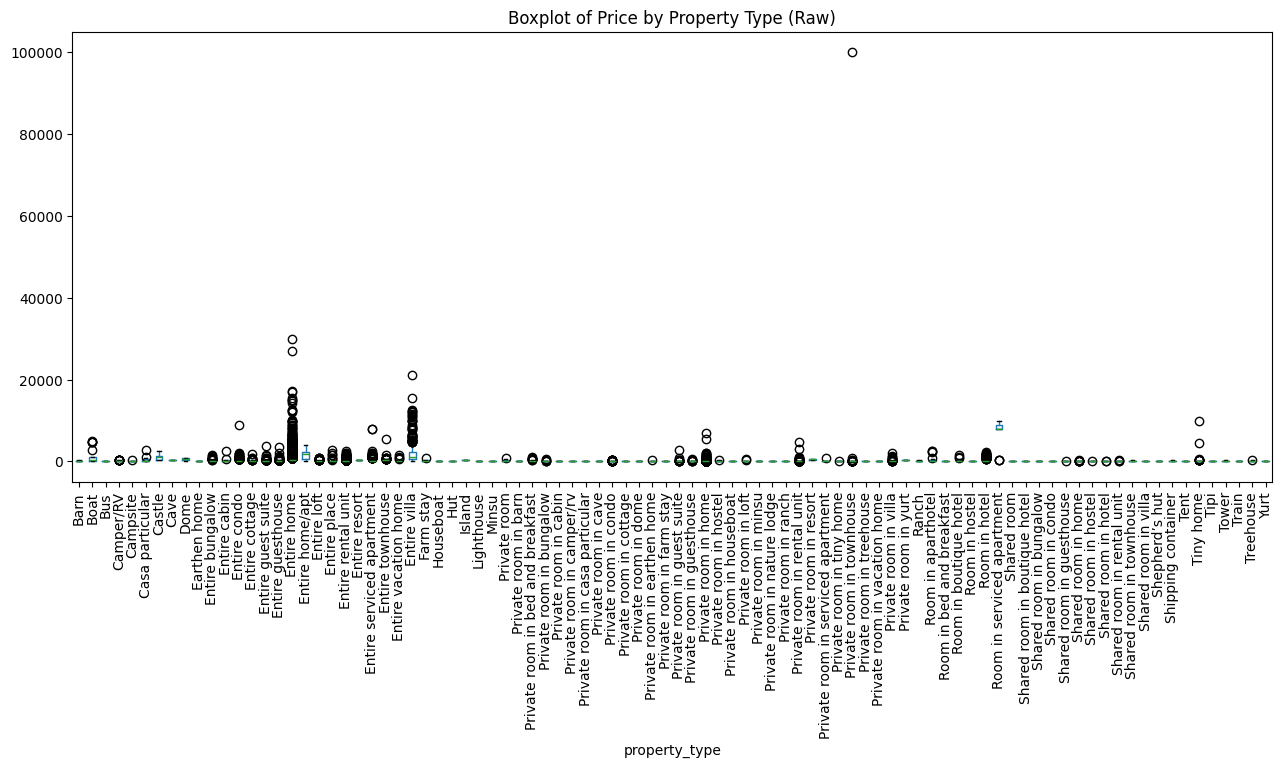

Capping prices at 99th percentile: $2500.00
Running Iterative Imputer...
[IterativeImputer] Completing matrix with shape (31957, 20)
[IterativeImputer] Ending imputation round 1/10, elapsed time 2.10
[IterativeImputer] Change: 2.6867442720687364, scaled tolerance: 2.5 
[IterativeImputer] Ending imputation round 2/10, elapsed time 4.12
[IterativeImputer] Change: 0.44347856995142276, scaled tolerance: 2.5 
[IterativeImputer] Early stopping criterion reached.
Cleaning Complete. Final shape: (31957, 67)


In [ ]:
testing_data_la = pd.read_csv('https://raw.githubusercontent.com/4mbrus/Data-Analysis-3/refs/heads/main/Assignment%201/LA_listings_Q1.csv')
testing_data_sd = pd.read_csv('https://raw.githubusercontent.com/4mbrus/Data-Analysis-3/refs/heads/main/Assignment%201/SD_listings_Q2.csv')

testing_data_la_clean = clean_airbnb_dataset(testing_data_la, 34.0536, -118.2430)
testing_data_la = testing_data_la_clean

In [19]:
testing_data_la.isna().sum() #cleaning successful

id                      0
host_id                 0
host_response_rate      0
host_acceptance_rate    0
host_is_superhost       0
                       ..
Beachfront              0
Streaming services      0
delta_lat               0
delta_lon               0
dist_to_center_km       0
Length: 67, dtype: int64

--- Starting Data Cleaning Pipeline ---
Original shape: (12959, 79)
Step 1 Complete: Structural columns dropped.
Step 4 Complete: Amenities processed and dummy variables created.

Visual Check: found 1763 listings with missing reviews.


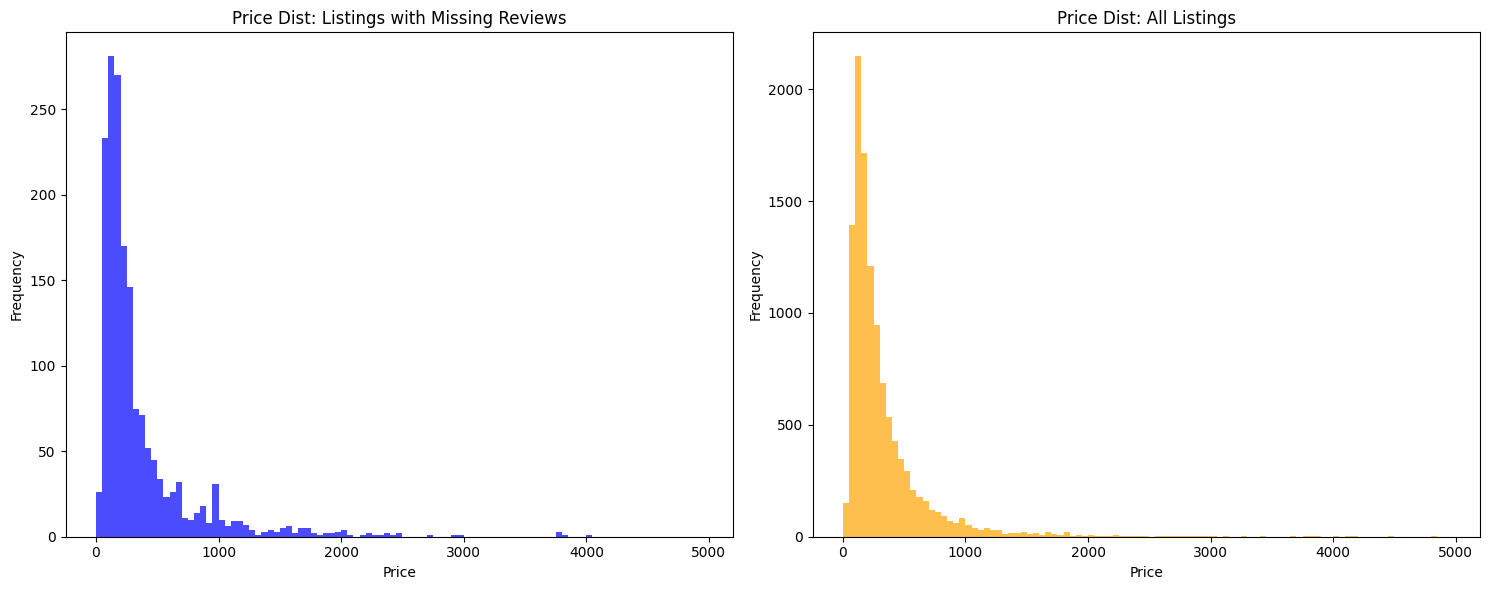

Interpretation: Distribution is normal. Assuming these are new listings.

Visual Check: Analyzing extreme values by property type...


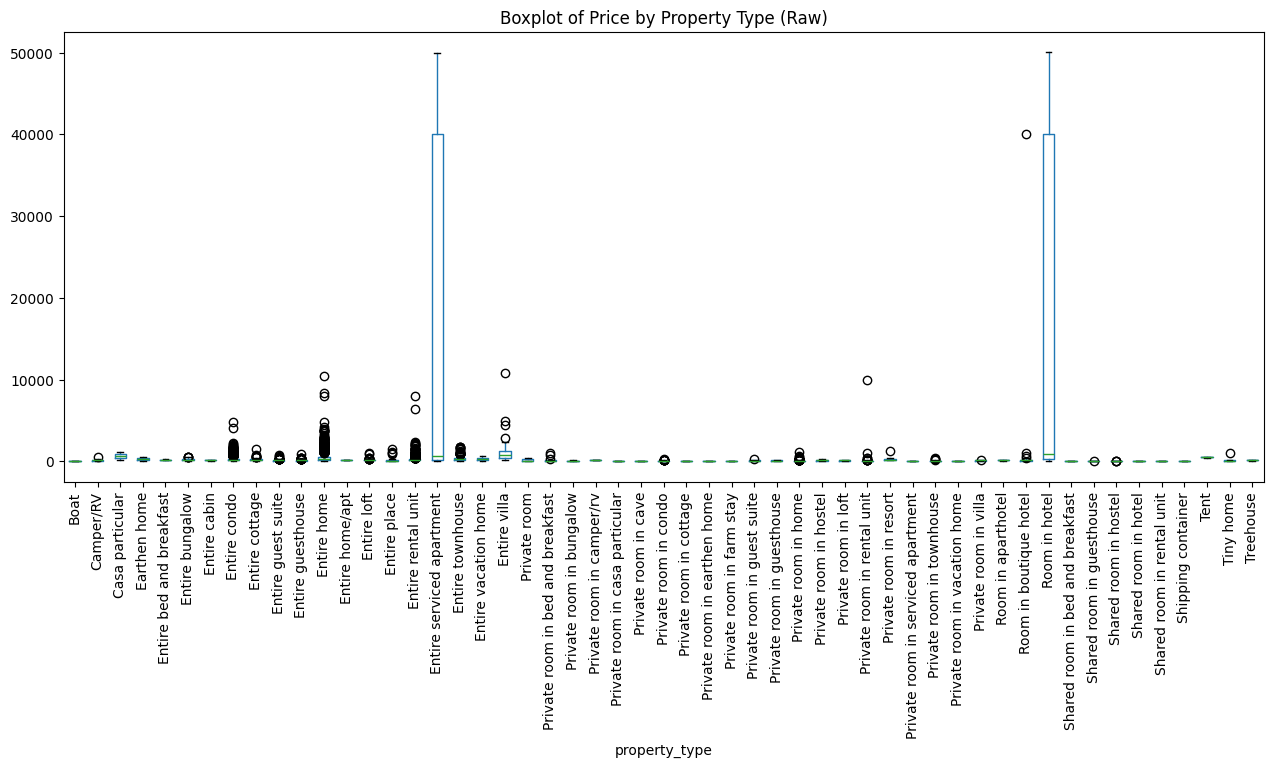

Capping prices at 99th percentile: $4407.60
Running Iterative Imputer...
[IterativeImputer] Completing matrix with shape (11401, 20)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.18
[IterativeImputer] Change: 0.7845364536859112, scaled tolerance: 4.1850000000000005 
[IterativeImputer] Early stopping criterion reached.
Cleaning Complete. Final shape: (11401, 67)


In [20]:
testing_data_sd_clean = clean_airbnb_dataset(testing_data_sd,32.7157,-117.1611)
testing_data_sd = testing_data_sd_clean

6. Use your 5 core models on the A. Later date and B. Other city data. Compare model performance and discuss the experience. (3p)

In [ ]:
def fit_all_models(new_dataset, trained_scaler, trained_columns):
    # 1. Prepare Target
    if 'price' not in new_dataset.columns:
        raise ValueError("Dataset needs 'price' column for evaluation.")
    y_actual = new_dataset['price']

    # 2. Prepare Features
    drop_cols = ['price', 'id', 'host_id', 'estimated_revenue_l365d']
    cat_cols = ['room_type', 'property_type']
    
    # Encode Categoricals
    X_cats = pd.get_dummies(new_dataset[cat_cols])
    
    # Get Numericals
    X_nums = new_dataset.drop(columns=drop_cols + cat_cols, errors='ignore')
    
    # Combine
    X = pd.concat([X_nums, X_cats], axis=1)
    
    # 3. Force Column Order & Alignment (The "Safety Lock")
    X.columns = [col.replace(' ', '_') for col in X.columns]
    X = X.reindex(columns=trained_columns, fill_value=0)

    # 4. Scale Data (We keep this ONLY for Lasso)
    X_scaled = pd.DataFrame(trained_scaler.transform(X), columns=X.columns)

    # 5. Hardcoded Models
    models = [
        ("OLS", ols_final),
        ("LASSO", lasso),
        ("RF", rf_random),
        ("GBR", best_gbr_model),
        ("XGB", best_xgb_model)
    ]

    # 6. Run Predictions
    metrics_list = []
    
    for name, model in models:
        try:
            # ONLY Lasso gets scaled data. 
            # OLS (Statsmodels) and Trees (RF/XGB) get the original X.
            if name == "LASSO":
                y_pred = model.predict(X_scaled.values)
            else:
                y_pred = model.predict(X)
            
            rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
            r2 = r2_score(y_actual, y_pred)
            
            metrics_list.append([name, rmse, r2])
        except Exception as e:
            print(f"Model {name} failed: {e}")
            metrics_list.append([name, np.nan, np.nan])

    return pd.DataFrame(metrics_list, columns=["Model", "RMSE", "R2 Score"])

In [22]:
la_Q1_results = fit_all_models(testing_data_la, scaler, original_cols)
la_Q1_results

,Model,RMSE,R2 Score
0,OLS,200.473250,0.478358
1,LASSO,194.214758,0.510420
2,RF,142.140320,0.737763
3,GBR,114.020376,0.831257
4,XGB,113.401850,0.833083


In [23]:
sd_Q2_results = fit_all_models(testing_data_sd, scaler, original_cols)
sd_Q2_results

,Model,RMSE,R2 Score
0,OLS,238.905585,0.496189
1,LASSO,239.469765,0.493806
2,RF,229.105309,0.536675
3,GBR,224.434357,0.555375
4,XGB,227.031295,0.545026


The comparison between the Los Angeles and San Diego test results highlights the critical difference between internal validity and external validity in machine learning models. On the Los Angeles test set, the advanced tree-based models (XGBoost and GBR) achieved exceptional performance with an $R^2$ exceeding 0.84, confirming that the models successfully learned the specific pricing structures and geographic rules of the source city. However, when applied to San Diego—a "zero-shot" transfer task where the models had zero training exposure—the predictive power dropped to an $R^2$ of approximately 0.54. While a drop is expected due to domain shift, the fact that the model still explains over 50% of the variance in a completely new city is a promising baseline. This discrepancy is largely driven by geographic feature mismatch; specifically, the dist_to_center feature likely confused the model because "proximity to center" implies lower value in Los Angeles (inland) but higher value in San Diego (coastal/Gaslamp). To bridge this gap and create a truly "city-agnostic" model, future iterations would need to replace specific geographic coordinates with universal value indicators, such as distance to coast or relative price scaling, to account for the differing "value languages" of these two cities.

## Overall Experience

Overall, I learned a lot from this assignment, though the process was often tiring and far from linear. I found myself constantly going back and forth—building what I thought was a solid model, only to realize later it wouldn't transfer, forcing me to restart repeatedly: dropping different columns, rewriting code, and waiting for parameter searches to run all over again.

Through this iterative cycle, I grasped the strategic complexity of data preprocessing. Deciding whether to impute missing data or drop columns wasn't just a technical step, but a decision that defined the model's integrity. A major challenge was location; neighborhood names were too specific, but simple "distance to center" metrics also failed because Los Angeles is "polycentric"—expensive areas exist both in the hills and at the coast. This meant a single distance feature couldn't capture the true price landscape, especially when transferring to a new city layout like San Diego.

In terms of algorithms, XGBoost and Gradient Boosting proved far superior to OLS and Random Forest in capturing these non-linear patterns. However, the drop in accuracy on the San Diego dataset confirmed that high internal performance often masks overfitting. This underscored that while boosting models are powerful, achieving true external validity requires strict parameter tuning and features that capture universal value rather than just local geometry.